<a href="https://colab.research.google.com/github/ericburdett/hwr/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple HWR

Implementation of Gated Convolutional Recurrent Neural Network for Handwriting Recognition as recorded in [Bluche](http://ieeexplore.ieee.org/document/8270042/).

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import time
from PIL import Image, ImageOps
import gc
import pdb
import pandas as pd
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp "drive/My Drive/datasets/iam.zip" "/content"
!unzip -q iam.zip
!rm iam.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Helper Functions

In [0]:
def word_lengths_tensor(words):
  lengths = []

  if type(words) == str:
    length = len(word)
    if length > 16:
      length = 16
    lengths.append(length)
    return torch.tensor(lengths)
  else:
    for word in words:
      length = len(word)
      if length > 16:
        length = 16
      lengths.append(length)
    return torch.tensor(lengths)

def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

### Dataset

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(32, 128)):
    if not os.path.exists('/content/labels.csv'):
      raise Exception('Iam dataset does not exist in /content/labels.csv')

    self.desired_size = desired_size
    self.path = '/content/images/'
    self.df = pd.read_csv('/content/labels.csv', sep='\t', header=None, names=['word', 'seg', 'transcription'])
    self.df = self.df.drop(['seg'], axis=1)
    self.df = self.df.drop(self.df[self.df['transcription'] == '.'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '!'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ','].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ';'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == ':'].index)    
    self.df = self.df.drop(self.df[self.df['transcription'] == ')'].index)
    self.df = self.df.drop(self.df[self.df['transcription'] == '('].index)
    self.df = self.df.reset_index()
    
  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    border_img = cv2.copyMakeBorder(
        img,
        top=border_top,
        bottom=0,
        left=0,
        right=border_right,
        borderType=cv2.BORDER_CONSTANT,
        value=[255]
    )

    return border_img

  def __getitem__(self, index):
    img = self.tensor_image('images/' + self.df['word'][index])

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

### Classes

In [0]:
# Static class for going back and forth between tensors and words
class Encoder():

  # input => (tuple of strings)
  def getRepresentation(words):
    charlists = []
    zeros = np.zeros(20)

    if type(words) == str:
      charlist = [ord(c) for c in words]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

      return torch.tensor(charlists).long().cuda()

    for word in words:
      charlist = [ord(c) for c in word]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

    return torch.tensor(charlists).long().unsqueeze(2).cuda()
  
  # input -> tensor containing representations of words (batch, sequence length)
  def getStrings(tensor):
    tensor = tensor.squeeze()

    words = []

    for indices in tensor:
      word = ''

      for index in indices:
        if index.item() != 0:
          letter = chr(index.item())
          word += letter
      
      words.append(word)
    
    return words

In [0]:
class Recognizer(nn.Module):
  def __init__(self):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.max_length = 20

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, 16)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [35]:
IamDataset()[0][0].shape

torch.Size([1, 32, 128])

In [46]:

r = Recognizer()
img = torch.randn(2, 1, 32, 128)
preds = r(img).permute(1, 0, 2)
preds = preds.argmax(dim=2)
Encoder.getStrings(preds)

['\x7f\x7f\x7fM(~\x7f\x7f\x7fMN\x7fu', '\x7f\x7f\x7fM(~\x7f\x7f\x7fMN\x7fu']

### Training

In [0]:
# In future, potentially apply gradient balancing

def train():
  try:
    EPOCHS = 200
    BATCH_SIZE = 350
    ITERATION_SAMPLE = 100

    dataset = IamDataset(desired_size=(32, 128))
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)) + 1, int(.2 * len(dataset))])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    recognizer = Recognizer().cuda()
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)
    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      # Train Loop
      for batch_num, (imgs, words) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        imgs, labels = imgs.cuda(), Encoder.getRepresentation(words).cuda()

        optimizer.zero_grad()

        word_labels = labels.squeeze().long()
        input_lengths = torch.full((batch_size,), 16, dtype=torch.long) # (BATCH_SIZE) -> Sequence_Length
        target_lengths = word_lengths_tensor(words) # (BATCH_SIZE) -> Word lengths

        preds = recognizer(imgs)

        loss = objective(preds, word_labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if batch_num % ITERATION_SAMPLE == 0:
          preds_strings = Encoder.getStrings(preds.permute(1, 0, 2).argmax(dim=2))
          print('\nTargets: ', words[:3])
          print('Predicted: ', preds_strings[:3])
          show_imgs(imgs[:3])
          plt.pause(1)

        loop.set_description('Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(train_losses)))

        loop.update(1)

      loop.close()

      gc.collect()

      val_loss_single = []
      # Validation Loop
      for val_batch_num, (val_imgs, val_words) in enumerate(val_loader):
        val_batch_size = val_imgs.shape[0]

        val_imgs, val_labels = val_imgs.cuda(), Encoder.getRepresentation(val_words).cuda()

        val_word_labels = val_labels.squeeze().long()
        val_input_lengths = torch.full((val_batch_size,), 16, dtype=torch.long)
        val_target_lengths = word_lengths_tensor(val_words)

        val_preds = recognizer(val_imgs)

        val_loss = objective(val_preds, val_word_labels, val_input_lengths, val_target_lengths)
        val_loss = torch.mean(val_loss)

        val_loss_single.append(val_loss.item())

      val_losses.append(np.mean(val_loss_single))

      print('Epoch: {}, Loss: {} '.format(epoch, val_losses[-1]))
    
  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, train_losses, val_losses

  0%|          | 0/197 [00:00<?, ?it/s]


Targets:  ('using', 'controlled', 'Vesuvius')
Predicted:  ['\x7f\x7f\x7f\x7f?}\x7f<\x7f\x7fD', '\x7f\x7f\x7f\x7f?}\x7f<\x7f\x7fD', '\x7f\x7f\x7f\x7f?}\x7f<\x7f\x7fD']


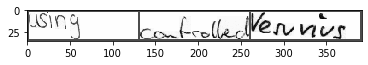

Epoch: 0, Loss: 17.4659, AvgLoss: 22.9454:  51%|█████     | 100/197 [01:06<01:01,  1.59it/s]


Targets:  ('lemon', 'in', 'curative')
Predicted:  ['', '', '']


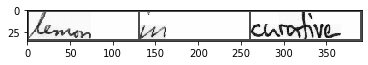

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 0, Loss: 16.425002212524415 

Targets:  ('beating', 'but', 'That')
Predicted:  ['', '', '']


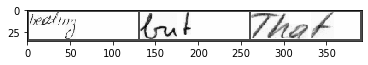

Epoch: 1, Loss: 16.8978, AvgLoss: 18.5264:  51%|█████     | 100/197 [01:05<01:01,  1.58it/s]


Targets:  ('orbit', 'explanation', "Macmillan's")
Predicted:  ['', '', '']


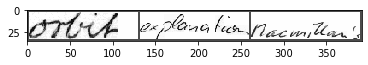

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 1, Loss: 15.93352222442627 

Targets:  ('elastic', 'into', 'Certainly')
Predicted:  ['', '', '']


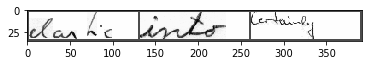

Epoch: 2, Loss: 15.7947, AvgLoss: 17.4570:  51%|█████     | 100/197 [01:05<01:02,  1.56it/s]


Targets:  ('still', 'regarded', 'of')
Predicted:  ['', '', '']


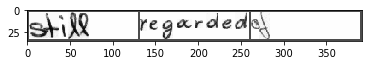

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 2, Loss: 15.26545831680298 

Targets:  ('fixed', 'ample', 'off')
Predicted:  ['a', 'o', 'a']


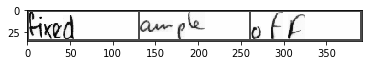

Epoch: 3, Loss: 14.6407, AvgLoss: 16.8382:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('Scots', 'This', 'caused')
Predicted:  ['a', 't', 'a']


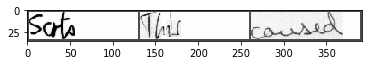

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 3, Loss: 14.607758407592774 

Targets:  ('windows', 'the', 'want')
Predicted:  ['a', 'a', 'a']


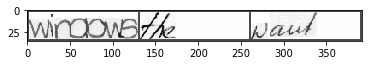

Epoch: 4, Loss: 14.6766, AvgLoss: 16.3182:  51%|█████     | 100/197 [01:05<01:01,  1.57it/s]


Targets:  ('God', 'on', 'new')
Predicted:  ['a', 'a', 'a']


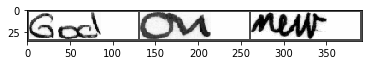

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 4, Loss: 14.157372589111327 

Targets:  ('size', 'head', 'the')
Predicted:  ['ae', 'ae', 't']


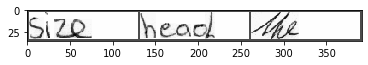

Epoch: 5, Loss: 13.7399, AvgLoss: 15.9165:  51%|█████     | 100/197 [01:05<01:01,  1.57it/s]


Targets:  ('venture', 'are', 'all')
Predicted:  ['a', 'a', 't']


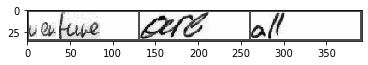

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 5, Loss: 14.021044979095459 

Targets:  ('backwater', 'salary', 'like')
Predicted:  ['eeed', 'ag', 'ae']


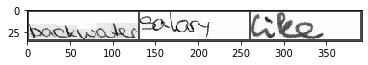

Epoch: 6, Loss: 13.7342, AvgLoss: 15.5945:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('gold', 'notorious', 'as')
Predicted:  ['ee', 'te', 'th']


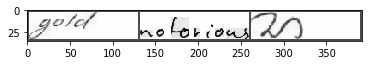

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 6, Loss: 13.61211923599243 

Targets:  ('in', 'in', 'fact')
Predicted:  ['th', 'i', 'a']


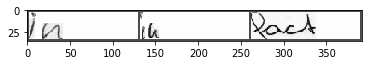

Epoch: 7, Loss: 13.0575, AvgLoss: 15.3070:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('were', 'to', 'out')
Predicted:  ['ah', 't', 'a']


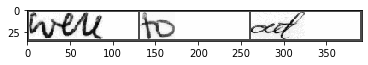

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 7, Loss: 19.1829634475708 

Targets:  ('the', 'someone', 'his')
Predicted:  ['ege', 'eme', 'ese']


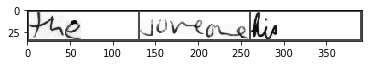

Epoch: 8, Loss: 14.9334, AvgLoss: 15.2148:  51%|█████     | 100/197 [01:05<01:01,  1.58it/s]


Targets:  ('Lily-yo', "'d", 'we')
Predicted:  ['ad', 'th', 'th']


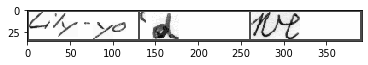

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 8, Loss: 14.114453449249268 

Targets:  ('were', 'me', 'sent')
Predicted:  ['e', 'ah', 'an']


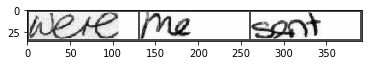

Epoch: 9, Loss: 13.1907, AvgLoss: 15.0891:  51%|█████     | 100/197 [01:05<01:01,  1.58it/s]


Targets:  ('who', 'burst', 'TO')
Predicted:  ['oh', '', 'a']


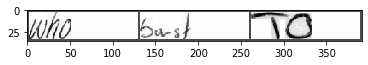

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 9, Loss: 13.527597904205322 

Targets:  ('unlikely', 'harvest', 'in')
Predicted:  ['et', 'et', 'ih']


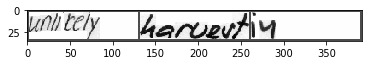

Epoch: 10, Loss: 13.2001, AvgLoss: 14.9282:  51%|█████     | 100/197 [01:05<01:01,  1.57it/s]


Targets:  ('false', 'and', 'knows')
Predicted:  ['f', 'at', 'at']


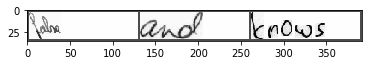

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 10, Loss: 13.049358558654784 

Targets:  ('-', 'understood', 'on')
Predicted:  ['ah', 'aete', 'a']


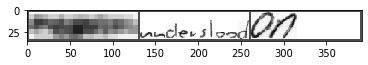

Epoch: 11, Loss: 13.1217, AvgLoss: 14.7541:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('You', 'go', 'has')
Predicted:  ['ha', 'of', 'h']


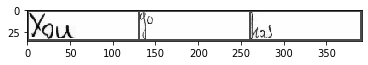

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 11, Loss: 12.60780433654785 

Targets:  ('cure', 'cities', 'full')
Predicted:  ['at', 'an', 'tfe']


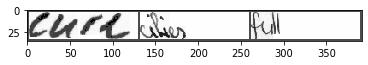

Epoch: 12, Loss: 12.6918, AvgLoss: 14.5728:  51%|█████     | 100/197 [01:05<01:01,  1.57it/s]


Targets:  ('Elizabeth', 'cast', 'of')
Predicted:  ['iten', 'wat', 'oo']


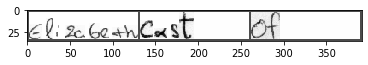

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 12, Loss: 12.475734691619873 

Targets:  ('out', 'in', 'Lords')
Predicted:  ['at', 'io', 'as']


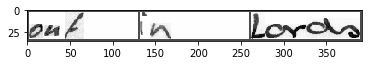

Epoch: 13, Loss: 11.8247, AvgLoss: 14.3983:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('Orsini', 'have', 'Morfydd')
Predicted:  ['Bat', 'at', 'egey']


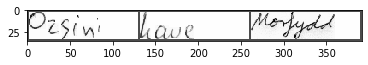

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 13, Loss: 11.872960758209228 

Targets:  ('correct', 'the', 'been')
Predicted:  ['at', 'the', 'ag']


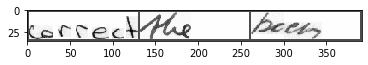

Epoch: 14, Loss: 11.6515, AvgLoss: 14.2189:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('this', 'landlord', 'Government')
Predicted:  ['th', 'ose', 'anen']


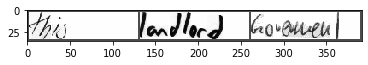

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 14, Loss: 11.459581909179688 

Targets:  ('Lee', 'this', 'George')
Predicted:  ['as', 'this', 'song']


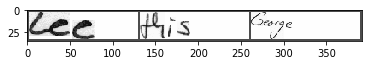

Epoch: 15, Loss: 10.9693, AvgLoss: 14.0353:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('fact', 'peace', 'as')
Predicted:  ['fat', 'fars', 'a']


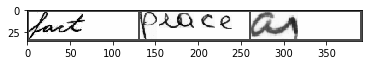

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 15, Loss: 11.057008056640624 

Targets:  ('not', 'a', 'than')
Predicted:  ['at', 'a', 'that']


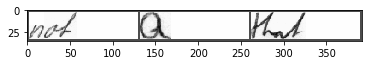

Epoch: 16, Loss: 10.4924, AvgLoss: 13.8502:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('feels', 'is', 'faster')
Predicted:  ['gel', 'is', 'fit']


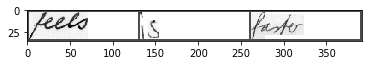

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 16, Loss: 10.831967506408692 

Targets:  ('no', 'not', 'been')
Predicted:  ['oe', 'was', 'ac']


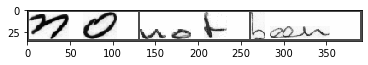

Epoch: 17, Loss: 10.0875, AvgLoss: 13.6647:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('at', 'Government', 'be')
Predicted:  ['of', 'sonoton', 'ee']


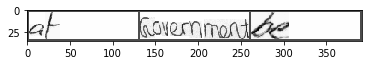

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 17, Loss: 10.361598472595215 

Targets:  ('with', 'distilled', 'disappointment')
Predicted:  ['with', 'citend', 'Cimmimuatonts']


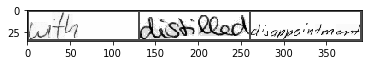

Epoch: 18, Loss: 10.0784, AvgLoss: 13.4739:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Sample', 'both', 'Hatfield')
Predicted:  ['Samny', 'fare', 'elan']


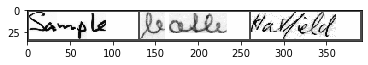

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 18, Loss: 10.051063442230225 

Targets:  ('life', 'of', 'over')
Predicted:  ['by', 'of', 'ases']


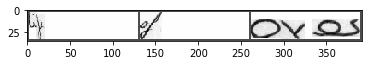

Epoch: 19, Loss: 9.3988, AvgLoss: 13.2881:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('attack', 'marriage', 'given')
Predicted:  ['ate', 'pragind', 'gin']


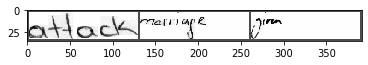

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 19, Loss: 9.605194473266602 

Targets:  ('took', 'he', 'Static')
Predicted:  ['thar', 'he', 'sit']


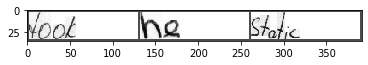

Epoch: 20, Loss: 9.1460, AvgLoss: 13.0987:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Then', '&', 'worth')
Predicted:  ['TTh', 'as', 'watt']


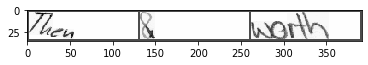

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 20, Loss: 9.283515453338623 

Targets:  ('13', 'lover', 'mother')
Predicted:  ['1is', 'dott', 'wotd']


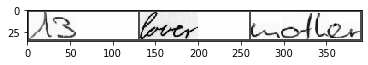

Epoch: 21, Loss: 8.0984, AvgLoss: 12.9110:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('groups', 'of', 'these')
Predicted:  ['posess', 'of', 'these']


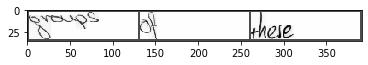

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 21, Loss: 8.99096628189087 

Targets:  ('1834', "'", 'was')
Predicted:  ['1as', "'", 'wos']


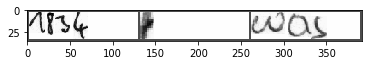

Epoch: 22, Loss: 8.4786, AvgLoss: 12.7244:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('poles', 'Henry', 'but')
Predicted:  ['palee', 'Homy', 'hot']


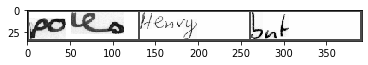

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 22, Loss: 8.726711711883546 

Targets:  ('I', 'by', 'talked')
Predicted:  ["'", 'by', 'thit']


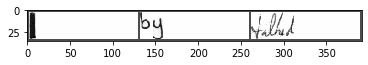

Epoch: 23, Loss: 9.1181, AvgLoss: 12.5371:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('The', 'of', 'recommendation')
Predicted:  ['The', 'of', 'ronorton']


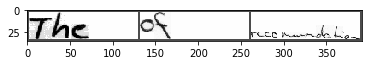

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 23, Loss: 8.34133957862854 

Targets:  ('to', 'enemy', 'is')
Predicted:  ['to', 'eerg', 'in']


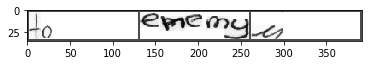

Epoch: 24, Loss: 7.7088, AvgLoss: 12.3513:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('of', 'the', 'paraded')
Predicted:  ['of', 'the', 'parataded']


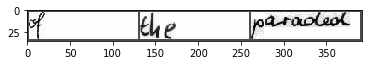

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 24, Loss: 8.29721417427063 

Targets:  ('me', 'went', 'serious-minded')
Predicted:  ['ne', 'wett', 'seitan']


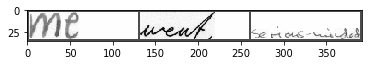

Epoch: 25, Loss: 6.8711, AvgLoss: 12.1670:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('danger', 'other', 'it')
Predicted:  ['dop', 'ortr', 'it']


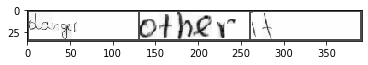

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 25, Loss: 7.774744281768799 

Targets:  ('those', 'injustice', 'Lady')
Predicted:  ['those', 'iinsiised', 'Lad']


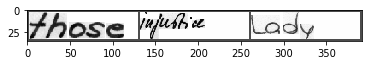

Epoch: 26, Loss: 7.0099, AvgLoss: 11.9834:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('the', 'in', 'out')
Predicted:  ['the', 'in', 'can']


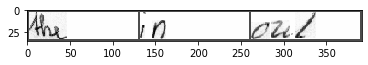

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 26, Loss: 7.475863065719604 

Targets:  ('the', 'British', 'fact')
Predicted:  ['the', 'Betiin', 'tat']


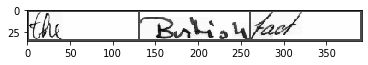

Epoch: 27, Loss: 7.4283, AvgLoss: 11.8039:  51%|█████     | 100/197 [01:06<01:01,  1.57it/s]


Targets:  ('Mr.', 'of', 'Submarines')
Predicted:  ['MMr.', 'of', 'Chormiens']


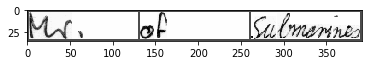

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 27, Loss: 7.321756381988525 

Targets:  ('for', 'in', 'his')
Predicted:  ['for', 'in', 'his']


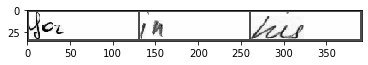

Epoch: 28, Loss: 6.7201, AvgLoss: 11.6263:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('died', 'seen', 'the')
Predicted:  ['Dikes', 'sen', 'the']


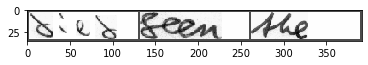

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 28, Loss: 7.167401142120362 

Targets:  ('and', 'the', 'of')
Predicted:  ['and', 'the', 'of']


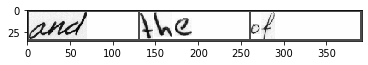

Epoch: 29, Loss: 7.0854, AvgLoss: 11.4532:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('life', 'another', 'Cecil')
Predicted:  ['if', 'motr', 'lec']


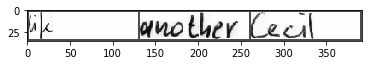

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 29, Loss: 7.000031290054321 

Targets:  ('Continent', 'cent', 'Grimstead')
Predicted:  ['Ciornmiin', 'cat', 'cirimteed']


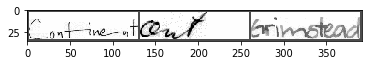

Epoch: 30, Loss: 6.2191, AvgLoss: 11.2820:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ("'", 'it', 'of')
Predicted:  ['I', 'it', 'of']


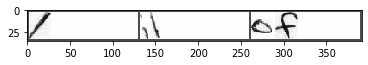

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 30, Loss: 6.76347954750061 

Targets:  ('ticket', "'", 'to')
Predicted:  ['tikd', "'", 'to']


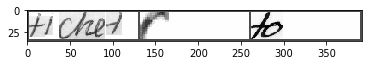

Epoch: 31, Loss: 5.9285, AvgLoss: 11.1149:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('to', 'arrival', 'in')
Predicted:  ['to', 'conivced', 'inn']


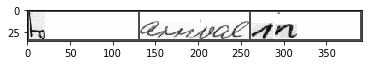

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 31, Loss: 6.667021331787109 

Targets:  ('Peel', 'that', '-')
Predicted:  ['Ped', 'tharr', '-']


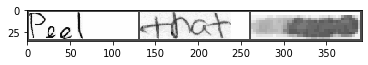

Epoch: 32, Loss: 5.7813, AvgLoss: 10.9508:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('were', "'", 'power')
Predicted:  ['wase', 'I', 'pocer']


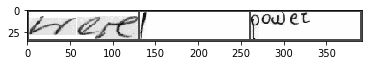

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 32, Loss: 6.597403697967529 

Targets:  ('automation', 'urge', 'a')
Predicted:  ['contttmaation', 'way', 'a']


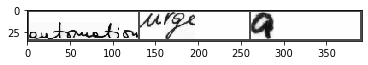

Epoch: 33, Loss: 5.4026, AvgLoss: 10.7907:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('done', 'of', 'the')
Predicted:  ['done', 'of', 'the']


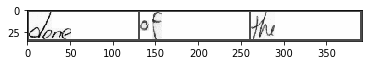

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 33, Loss: 6.482358589172363 

Targets:  ('in', 'plan', 'amazing')
Predicted:  ['in', 'plan', 'aanaing']


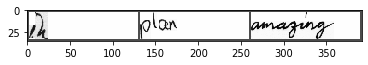

Epoch: 34, Loss: 5.3666, AvgLoss: 10.6331:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('afraid', 'and', 'that')
Predicted:  ['aarred', 'and', 'that']


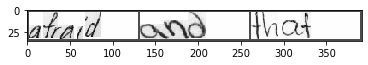

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 34, Loss: 6.30327919960022 

Targets:  ('food', 'pitch', 'to')
Predicted:  ['food', 'putee', 'to']


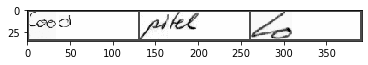

Epoch: 35, Loss: 5.2072, AvgLoss: 10.4803:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Roy', 'than', 'packages')
Predicted:  ['Rey', 'than', 'peeans']


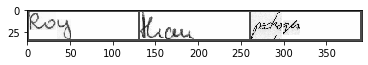

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 35, Loss: 6.171197671890258 

Targets:  ('a', 'hand-picked', 'and')
Predicted:  ['a', 'homd-npiced', 'and']


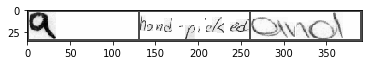

Epoch: 36, Loss: 5.6082, AvgLoss: 10.3308:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('that', 'addicts', 'faced')
Predicted:  ['that', 'aoiines', 'fedl']


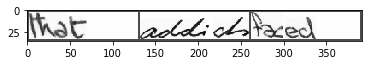

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 36, Loss: 6.208023624420166 

Targets:  ('a', 'then', 'after')
Predicted:  ['a', 'then', 'aoft']


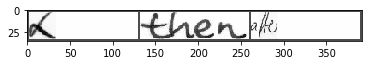

Epoch: 37, Loss: 4.5834, AvgLoss: 10.1840:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('and', 'base', 'not')
Predicted:  ['and', 'base', 'not']


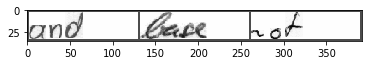

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 37, Loss: 6.146680011749267 

Targets:  ('in', "'d", 'Bawley')
Predicted:  ['in', "'d", 'Boarriny']


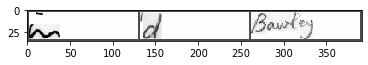

Epoch: 38, Loss: 4.7703, AvgLoss: 10.0408:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('about', 'turning', 'there')
Predicted:  ['aabuut', 'trning', 'theree']


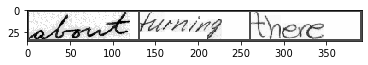

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 38, Loss: 6.047916078567505 

Targets:  ('God', 'essentially', 'have')
Predicted:  ['God', 'eesserititns', 'havee']


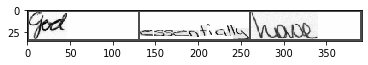

Epoch: 39, Loss: 4.4337, AvgLoss: 9.9009:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('fought', 'Neapolitan', 'as')
Predicted:  ['Couughont', 'Nerpoliattan', 'a']


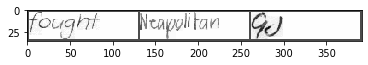

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 39, Loss: 6.102549381256104 

Targets:  ('He', 'man', 'man')
Predicted:  ['He', 'man', 'man']


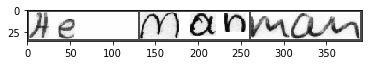

Epoch: 40, Loss: 4.2315, AvgLoss: 9.7637:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('-', 'at', 'that')
Predicted:  ['-', 'at', 'tat']


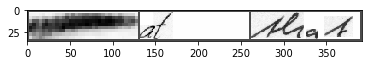

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 40, Loss: 6.023733386993408 

Targets:  ('posed', 'Her', 'the')
Predicted:  ['pasd', 'pher', 'the']


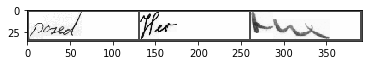

Epoch: 41, Loss: 4.6779, AvgLoss: 9.6293:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('instance', 'on', 'fittings')
Predicted:  ['iintance', 'on', 'thingh']


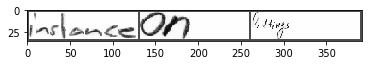

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 41, Loss: 6.022029962539673 

Targets:  ('inter-', 'boy', 'as')
Predicted:  ['ior-', 'boy', 'as']


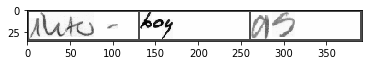

Epoch: 42, Loss: 3.8954, AvgLoss: 9.4968:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Capetown', 'to', 'patients')
Predicted:  ['Caetony', 'to', 'paients']


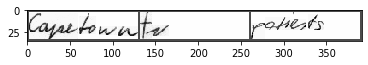

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 42, Loss: 5.936072216033936 

Targets:  ('and', 'Egyptians', 'her')
Predicted:  ['and', 'Eptians', 'her']


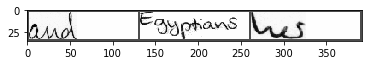

Epoch: 43, Loss: 3.5807, AvgLoss: 9.3669:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('on', 'he', 'now')
Predicted:  ['on', 'be', 'now']


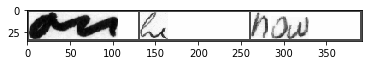

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 43, Loss: 5.923179512023926 

Targets:  ('to', 'necessary', 'in')
Predicted:  ['to', 'merrany', 'in']


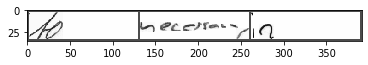

Epoch: 44, Loss: 3.1382, AvgLoss: 9.2406:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('a', 'she', 'then')
Predicted:  ['a', 'she', 'then']


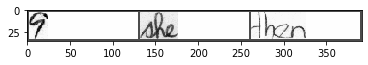

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 44, Loss: 5.995251779556274 

Targets:  ('adding', 'West', 'gone')
Predicted:  ['adiing', 'Wat', 'gome']


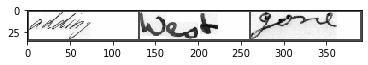

Epoch: 45, Loss: 3.9808, AvgLoss: 9.1167:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('of', 'he', 'which')
Predicted:  ['of', 'he', 'which']


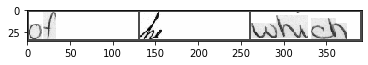

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 45, Loss: 6.045451049804687 

Targets:  ('out', 'the', 'the')
Predicted:  ['out', 'thee', 'thee']


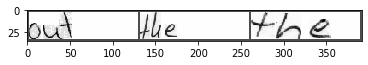

Epoch: 46, Loss: 3.2948, AvgLoss: 8.9948:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('of', 'In', 'of')
Predicted:  ['of', 'In', 'of']


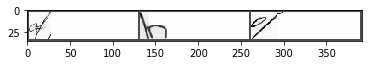

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 46, Loss: 6.127190523147583 

Targets:  ('-', '39', 'conditions')
Predicted:  ['-', '38', 'condiiiitions']


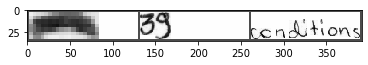

Epoch: 47, Loss: 3.3835, AvgLoss: 8.8746:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('as', 'by', 'under-')
Predicted:  ['as', 'by', 'undde-']


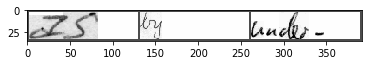

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 47, Loss: 6.111265678405761 

Targets:  ('forty', 'rents', 'you')
Predicted:  ['furny', 'remts', 'yu']


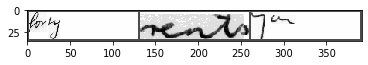

Epoch: 48, Loss: 3.1318, AvgLoss: 8.7571:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('to', "'", 'actually')
Predicted:  ['to', "'", 'aactaly']


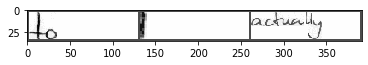

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 48, Loss: 6.104094667434692 

Targets:  ('Christian', 'at', 'of')
Predicted:  ['Cricstian', 'at', 'of']


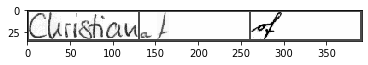

Epoch: 49, Loss: 2.6918, AvgLoss: 8.6419:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('the', 'of', 'eyes')
Predicted:  ['thee', 'of', 'eyys']


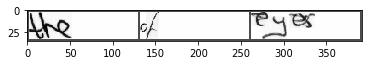

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 49, Loss: 6.226024265289307 

Targets:  ('anaesthetists', 'chance', 'imagination')
Predicted:  ['aandrstntiitiss', 'chancee', 'iimginaatton']


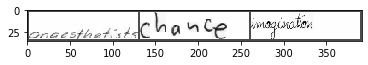

Epoch: 50, Loss: 3.0993, AvgLoss: 8.5301:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('the', 'parted', 'We')
Predicted:  ['thee', 'pafedd', 'We']


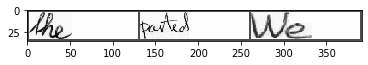

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 50, Loss: 6.38981915473938 

Targets:  ('turn', 'was', 'a')
Predicted:  ['tern', 'was', 'a']


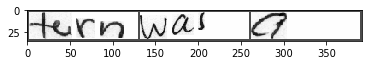

Epoch: 51, Loss: 2.9412, AvgLoss: 8.4184:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Haris', 'newly', 'with')
Predicted:  ['Haris', 'paly', 'with']


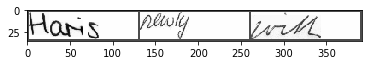

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 51, Loss: 6.390600299835205 

Targets:  ('octopus', 'But', 'is')
Predicted:  ['ooclas', 'Bul', 'is']


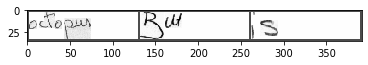

Epoch: 52, Loss: 2.5244, AvgLoss: 8.3084:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('after', 'company', 'disaster')
Predicted:  ['efer', 'company', 'disuster']


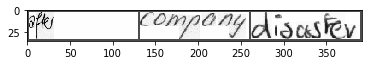

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 52, Loss: 6.55287127494812 

Targets:  ('grounds', 'the', 'looking')
Predicted:  ['grounss', 'thee', 'lookingg']


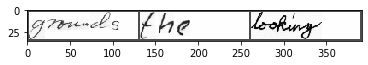

Epoch: 53, Loss: 2.3508, AvgLoss: 8.2008:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('President', 'the', 'had')
Predicted:  ['Preiidentt', 'thee', 'had']


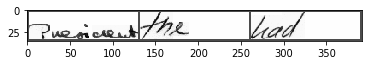

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 53, Loss: 6.665553979873657 

Targets:  ('down', 'it', 'proposals')
Predicted:  ['donn', 'it', 'prrepopasss']


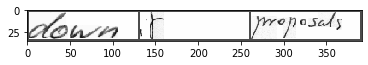

Epoch: 54, Loss: 2.3799, AvgLoss: 8.0959:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Hammarskjold', 'flat', 'put')
Predicted:  ["Hammarrsrtol'd", 'falt', 'put']


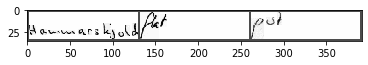

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 54, Loss: 6.72681245803833 

Targets:  ('which', 'anger', 'baby')
Predicted:  ['which', 'anger', 'baby']


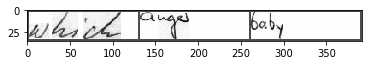

Epoch: 55, Loss: 2.1454, AvgLoss: 7.9925:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('now', 'minds', 'her')
Predicted:  ['now', 'mids', 'wer']


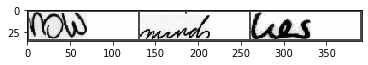

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 55, Loss: 6.728403873443604 

Targets:  ('the', 'some', 'passport')
Predicted:  ['the', 'somee', 'pappoont']


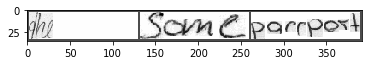

Epoch: 56, Loss: 2.1427, AvgLoss: 7.8899:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('drink', 'illness', 'to')
Predicted:  ['drink', 'ilness', 'to']


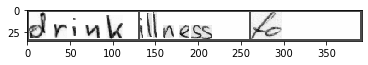

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 56, Loss: 6.931025953292846 

Targets:  ('that', "'", 'seemed')
Predicted:  ['that', "'", 'seemed']


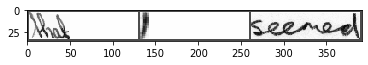

Epoch: 57, Loss: 2.3649, AvgLoss: 7.7905:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('throughout', 'infarction', 'Dr.')
Predicted:  ['thhrougholtt', 'iinfarrtion', 'are']


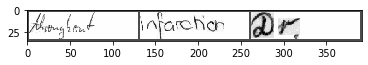

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 57, Loss: 7.023923692703247 

Targets:  ('by', 'welfare', 'point')
Predicted:  ['by', 'reeforee', 'poaintt']


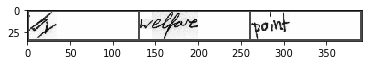

Epoch: 58, Loss: 1.7160, AvgLoss: 7.6913:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('run', 'I', 'she')
Predicted:  ['run', 'I', 'she']


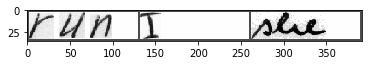

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 58, Loss: 7.0271759033203125 

Targets:  ('months', 'of', 'the')
Predicted:  ['momts', 'of', 'the']


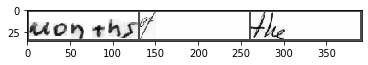

Epoch: 59, Loss: 1.8713, AvgLoss: 7.5942:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('the', 'Mr.', 'obtained')
Predicted:  ['tthee', 'Mr.', 'oobtiined']


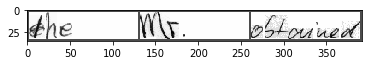

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 59, Loss: 7.14433518409729 

Targets:  ('decent', 'being', 'suit')
Predicted:  ['deccent', 'beeing', 'suit']


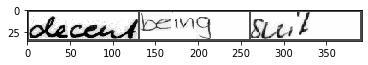

Epoch: 60, Loss: 1.4747, AvgLoss: 7.4989:  51%|█████     | 100/197 [01:06<01:01,  1.56it/s]


Targets:  ('is', 'same', 'about')
Predicted:  ['is', 'same', 'aaeouut']


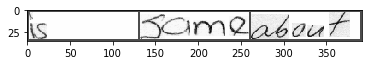

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 60, Loss: 7.366636018753052 

Targets:  ('this', 'appeal', 'Red')
Predicted:  ['this', 'aappeal', 'Red']


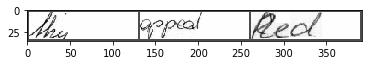

Epoch: 61, Loss: 1.7307, AvgLoss: 7.4056:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Minister', 'flattened', '-')
Predicted:  ['Ministen', 'fatterdd', '-']


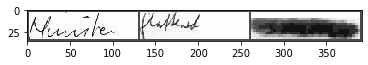

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 61, Loss: 7.546297397613525 

Targets:  ('policy', 'bismuth-210', 'sections')
Predicted:  ['poliicy', 'bismmuuttth-210', 'setions']


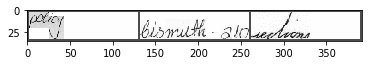

Epoch: 62, Loss: 1.6588, AvgLoss: 7.3146:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('offer', 'Peel', 'he')
Predicted:  ['oofers', 'Peel', 'hhe']


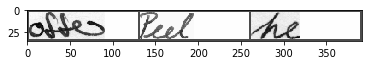

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 62, Loss: 7.5623972034454345 

Targets:  ('Money', 'firms', 'phrase')
Predicted:  ['Money', 'fims', 'ploase']


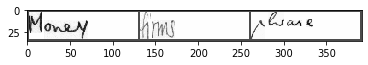

Epoch: 63, Loss: 1.8382, AvgLoss: 7.2249:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('eye', 'used', 'as')
Predicted:  ['Tye', 'uset', 'as']


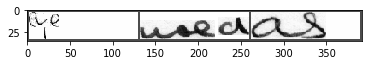

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 63, Loss: 7.626904153823853 

Targets:  ('nuns', 'Mr.', 'retorted')
Predicted:  ['nuns', 'Mr.', 'rettorted']


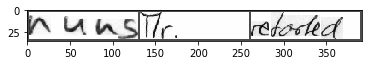

Epoch: 64, Loss: 1.5536, AvgLoss: 7.1374:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('chinchilla', "'", 'what')
Predicted:  ['chilbille', "'", 'what']


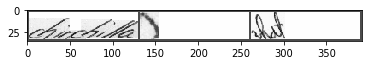

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 64, Loss: 7.779013833999634 

Targets:  ('sharpness', 'to', 'its')
Predicted:  ['shaypesss', 'to', 'its']


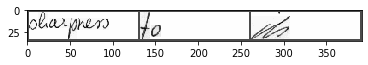

Epoch: 65, Loss: 1.6225, AvgLoss: 7.0506:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('in', 'could', 'occurred')
Predicted:  ['in', 'could', 'ooccurred']


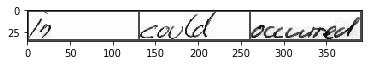

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 65, Loss: 7.991052284240722 

Targets:  ('is', 'it', 'in')
Predicted:  ['is', 'iit', 'in']


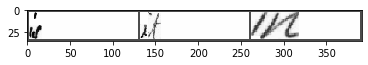

Epoch: 66, Loss: 1.2393, AvgLoss: 6.9647:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('and', 'have', 'she')
Predicted:  ['and', 'havee', 'shee']


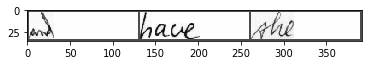

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 66, Loss: 8.049620962142944 

Targets:  ('be', 'a', 'chemists')
Predicted:  ['be', 'a', 'chemiasts']


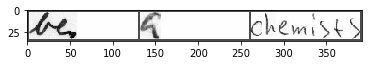

Epoch: 67, Loss: 1.2231, AvgLoss: 6.8812:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('supplied', 'and', 'Wicki')
Predicted:  ['supppliied', 'and', 'Wicki']


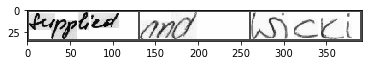

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 67, Loss: 8.093928050994872 

Targets:  ('their', 'Christian', 'of')
Predicted:  ['their', 'Chrictan', 'of']


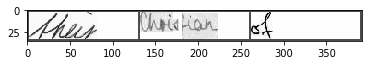

Epoch: 68, Loss: 1.1218, AvgLoss: 6.7993:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('his', 'and', 'of')
Predicted:  ['hiis', 'andd', 'of']


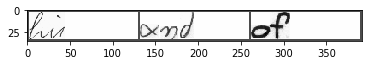

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 68, Loss: 8.223311223983764 

Targets:  ('the', 'Catherine', 'ful')
Predicted:  ['thee', 'Catherinee', 'ful']


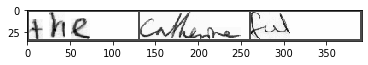

Epoch: 69, Loss: 1.0520, AvgLoss: 6.7186:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('towards', 'Secretariat', 'the')
Predicted:  ['towards', 'Secereaaatiatttt', 'the']


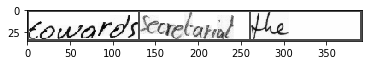

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 69, Loss: 8.43308168411255 

Targets:  ('to', 'was', 'big')
Predicted:  ['to', 'was', 'tog']


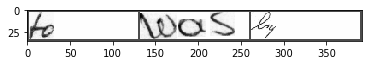

Epoch: 70, Loss: 1.2777, AvgLoss: 6.6400:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Continent', 'got', 'be')
Predicted:  ['Contiiimenttt', 'gt', 'be']


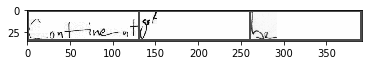

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 70, Loss: 8.624151964187622 

Targets:  ('ciency', 'a', 'vocabulary')
Predicted:  ['cieny', 'a', 'vocccabiulary']


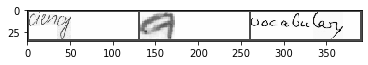

Epoch: 71, Loss: 1.1728, AvgLoss: 6.5640:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('to', 'list', 'We')
Predicted:  ['to', 'list', 'Wee']


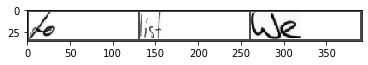

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 71, Loss: 8.648388586044312 

Targets:  ("Anglesey's", 'oz.', 'estranged')
Predicted:  ["AAnglssey's", 'os..', 'estranged']


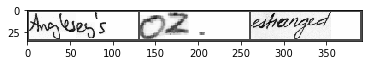

Epoch: 72, Loss: 1.1539, AvgLoss: 6.4900:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Mr.', 'that', 'in')
Predicted:  ['Mr..', 'that', 'in']


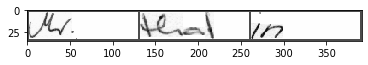

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 72, Loss: 8.780527076721192 

Targets:  ('know', 'gather', 'Morfydd')
Predicted:  ['know', 'gater', 'Motpadds']


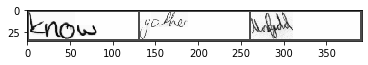

Epoch: 73, Loss: 1.1873, AvgLoss: 6.4175:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('piece', 'there', 'bay')
Predicted:  ['pieecee', 'theree', 'day']


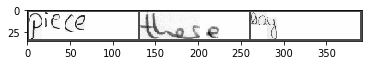

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 73, Loss: 8.955190887451172 

Targets:  ('whereas', 'golden', 'or')
Predicted:  ['whereas', 'gooden', 'or']


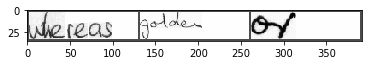

Epoch: 74, Loss: 0.8526, AvgLoss: 6.3443:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('missiles', 'General', 'share')
Predicted:  ['missiles', 'General', 'sharee']


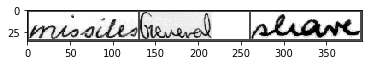

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 74, Loss: 9.193929281234741 

Targets:  ('servants', 'the', 'of')
Predicted:  ['sevvants', 'the', 'of']


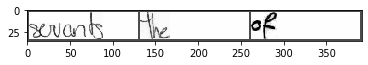

Epoch: 75, Loss: 0.8329, AvgLoss: 6.2745:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('to', 'with', 'series')
Predicted:  ['to', 'with', 'seriiies']


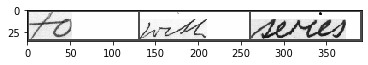

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 75, Loss: 9.107612600326538 

Targets:  ('down', 'control', 'of')
Predicted:  ['down', 'control', 'of']


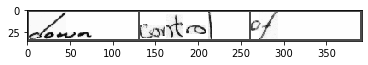

Epoch: 76, Loss: 0.6844, AvgLoss: 6.2049:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('endeavour', 'and', 'first')
Predicted:  ['eenddeavour', 'and', 'first']


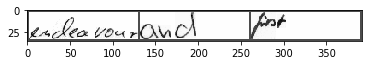

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 76, Loss: 9.183275079727172 

Targets:  ('You', 'were', 'Hahnemann')
Predicted:  ['You', 'weree', 'Haahnemannn']


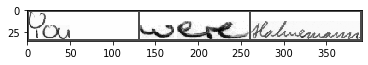

Epoch: 77, Loss: 0.7992, AvgLoss: 6.1358:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('spoke', 'the', 'agreed')
Predicted:  ['spokee', 'the', 'sageed']


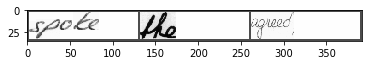

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 77, Loss: 9.227403516769408 

Targets:  ('contains', 'Bill', 'back')
Predicted:  ['contaiins', 'Biill', 'back']


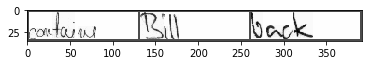

Epoch: 78, Loss: 0.8726, AvgLoss: 6.0695:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('that', 'the', 'green')
Predicted:  ['that', 'the', 'green']


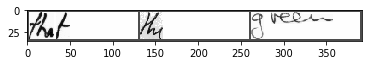

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 78, Loss: 9.474933938980103 

Targets:  ('alkaline', 'by', 'have')
Predicted:  ['aaleliine', 'by', 'havee']


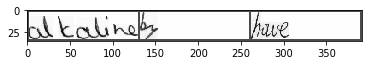

Epoch: 79, Loss: 0.8678, AvgLoss: 6.0042:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('perfidious', 'and', 'the')
Predicted:  ['perfiidious', 'andd', 'thee']


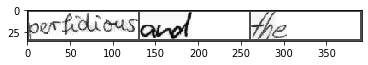

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 79, Loss: 9.600121631622315 

Targets:  ('at', 'honeymoon', 'was')
Predicted:  ['at', 'homywon', 'was']


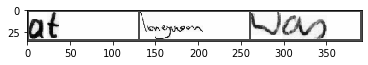

Epoch: 80, Loss: 1.0094, AvgLoss: 5.9409:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('I', 'with', 'not')
Predicted:  ['I', 'with', 'not']


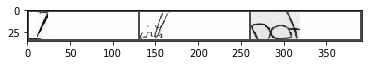

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 80, Loss: 9.62731653213501 

Targets:  ('I', 'which', 'is')
Predicted:  ['I', 'which', 'is']


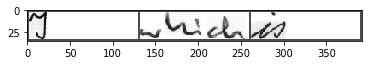

Epoch: 81, Loss: 0.9135, AvgLoss: 5.8800:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('LORD', 'course', 'even-tempered')
Predicted:  ['LOORD', 'couurrsee', 'eeven-temppereed']


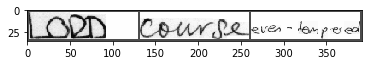

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 81, Loss: 9.827648372650147 

Targets:  ('before', 'effective', 'and')
Predicted:  ['beforee', 'eeffectiive', 'and']


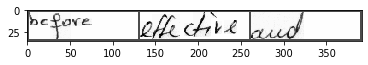

Epoch: 82, Loss: 0.8990, AvgLoss: 5.8193:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('Database', 'And', 'as')
Predicted:  ['Dataaasee', 'And', 'as']


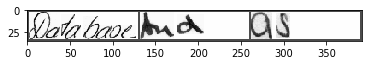

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 82, Loss: 9.727551918029786 

Targets:  ('on', 'in', 'himself')
Predicted:  ['on', 'in', 'hhimself']


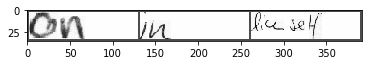

Epoch: 83, Loss: 0.7689, AvgLoss: 5.7588:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('saving', 'that', 'it')
Predicted:  ['savingg', 'that', 'it']


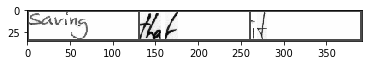

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 83, Loss: 9.969597721099854 

Targets:  ("'", 'It', 'A')
Predicted:  ["'", 'It', 'A']


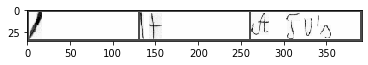

Epoch: 84, Loss: 0.8332, AvgLoss: 5.7003:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('or', 'about', 'truth')
Predicted:  ['or', 'aabouutt', 'truth']


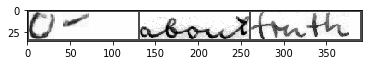

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 84, Loss: 9.8735284614563 

Targets:  ('was', 'same', 'peers')
Predicted:  ['was', 'samee', 'peers']


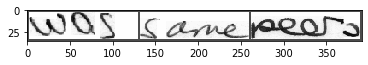

Epoch: 85, Loss: 0.7567, AvgLoss: 5.6442:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('war', 'we', 'many')
Predicted:  ['war', 'we', 'many']


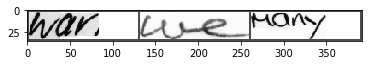

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 85, Loss: 9.997430448532105 

Targets:  ('it', 'you', 'other')
Predicted:  ['iit', 'you', 'oother']


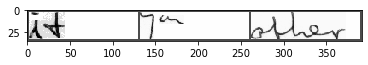

Epoch: 86, Loss: 0.7459, AvgLoss: 5.5883:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('little', 'evening', 'applying')
Predicted:  ['little', 'eveningg', 'aapplyiingg']


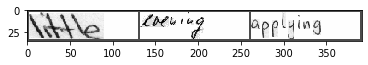

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 86, Loss: 10.014207344055176 

Targets:  ('her', 'she', 'placing')
Predicted:  ['her', 'shee', 'placingg']


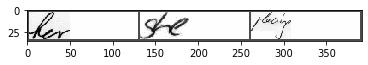

Epoch: 87, Loss: 0.5319, AvgLoss: 5.5318:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('stronger', 'End', 'the')
Predicted:  ['stronger', 'End', 'the']


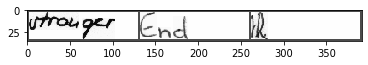

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 87, Loss: 10.191753044128419 

Targets:  ('that', 'room', 'American')
Predicted:  ['that', 'room', 'AArerican']


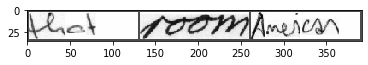

Epoch: 88, Loss: 0.5974, AvgLoss: 5.4778:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ("'", 'Their', 'talks')
Predicted:  ["''", 'Their', 'taks']


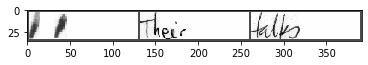

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 88, Loss: 10.285194969177246 

Targets:  ('doorway', '-', 'the')
Predicted:  ['doorway', '-', 'the']


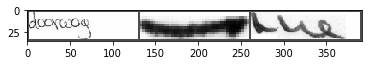

Epoch: 89, Loss: 0.7389, AvgLoss: 5.4251:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('accommodation', 'been', 'to')
Predicted:  ['accconmmodation', 'beeen', 'to']


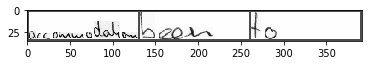

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 89, Loss: 10.28360288619995 

Targets:  ('stations', 'John', 'danger')
Predicted:  ['stations', 'John', 'danger']


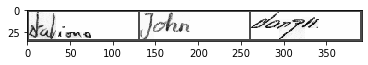

Epoch: 90, Loss: 0.8907, AvgLoss: 5.3744:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('environs', 'the', 'be')
Predicted:  ['eenrirons', 'the', 'be']


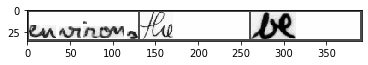

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 90, Loss: 10.202273979187012 

Targets:  ('I', 'Three', 'her')
Predicted:  ['I', 'Threne', 'ber']


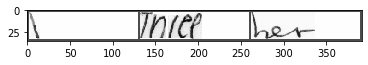

Epoch: 91, Loss: 0.8630, AvgLoss: 5.3242:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('aged', 'walk', 'Malin')
Predicted:  ['aogd', 'wale', 'Maliin']


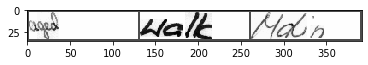

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 91, Loss: 10.240529747009278 

Targets:  ('that', 'whether', 'enable')
Predicted:  ['that', 'whemlher', 'enablee']


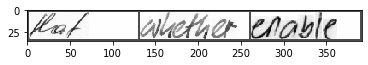

Epoch: 92, Loss: 0.9092, AvgLoss: 5.2754:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('installation', 'view', '-')
Predicted:  ['iinstallaation', 'view', '-']


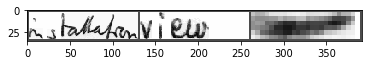

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 92, Loss: 10.467995319366455 

Targets:  ('of', 'building', 'terms')
Predicted:  ['oof', 'building', 'terms']


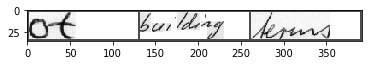

Epoch: 93, Loss: 0.4377, AvgLoss: 5.2273:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('need', 'is', 'sick')
Predicted:  ['need', 'is', 'sick']


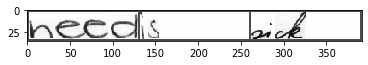

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 93, Loss: 10.450814914703368 

Targets:  ('major', 'husband', 'Britain')
Predicted:  ['majirr', 'husbandd', 'Britain']


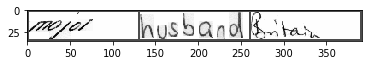

Epoch: 94, Loss: 0.5740, AvgLoss: 5.1791:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('I', 'the', 'cash')
Predicted:  ['II', 'the', 'cosh']


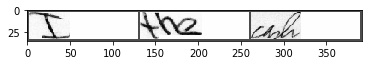

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 94, Loss: 10.677982921600341 

Targets:  ('and', 'In', 'on')
Predicted:  ['and', 'In', 'on']


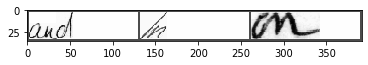

Epoch: 95, Loss: 0.5092, AvgLoss: 5.1301:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('well', 'under', 'simple')
Predicted:  ['well', 'undeer', 'simplee']


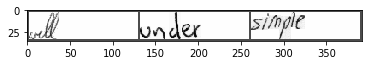

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 95, Loss: 10.755747985839843 

Targets:  ('Valet', 'known', 'to')
Predicted:  ['Valet', 'known', 'to']


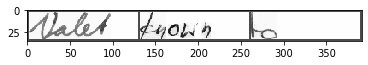

Epoch: 96, Loss: 0.6188, AvgLoss: 5.0823:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('reasonably', 'likely', 'defeat')
Predicted:  ['reasonably', 'liiikely', 'defeat']


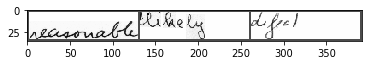

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 96, Loss: 11.199453201293945 

Targets:  ('the', 'of', 'not')
Predicted:  ['the', 'oof', 'not']


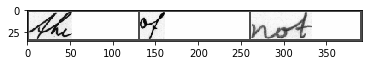

Epoch: 97, Loss: 0.8133, AvgLoss: 5.0381:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('its', 'A', 'of')
Predicted:  ['itts', 'A', 'oof']


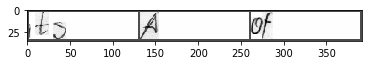

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 97, Loss: 10.783542747497558 

Targets:  ('Russell', 'at', 'of')
Predicted:  ['Russell', 'at', 'of']


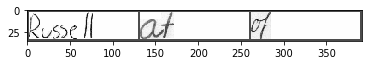

Epoch: 98, Loss: 0.6847, AvgLoss: 4.9949:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('but', 'in', 'rest')
Predicted:  ['but', 'in', 'rest']


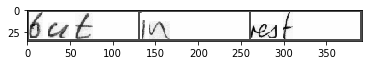

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 98, Loss: 10.95828932762146 

Targets:  ('the', 'got', 'consulted')
Predicted:  ['the', 'got', 'consultted']


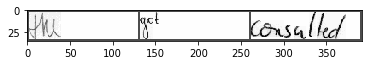

Epoch: 99, Loss: 0.6767, AvgLoss: 4.9532:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('When', 'need', 'have')
Predicted:  ['When', 'need', 'havee']


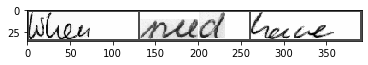

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 99, Loss: 10.752230854034424 

Targets:  ('the', 'former', 'textual')
Predicted:  ['the', 'former', 'textulll']


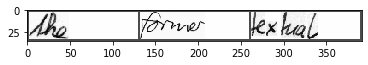

Epoch: 100, Loss: 0.5146, AvgLoss: 4.9108:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('as', 'of', 'coupled')
Predicted:  ['as', 'of', 'couupled']


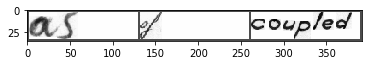

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 100, Loss: 11.047329139709472 

Targets:  ('morality', 'human', 'the')
Predicted:  ['moraality', 'human', 'the']


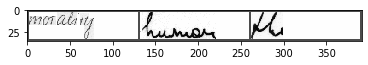

Epoch: 101, Loss: 0.3382, AvgLoss: 4.8671:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('going', 'of', 'Easy')
Predicted:  ['going', 'of', 'Easy']


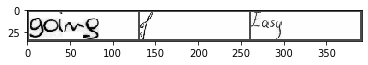

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 101, Loss: 10.962079772949219 

Targets:  ('doctor', 'had', 'it')
Predicted:  ['doctor', 'had', 'cit']


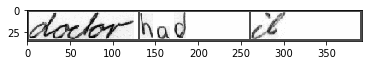

Epoch: 102, Loss: 0.5953, AvgLoss: 4.8237:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('funny', 'bit', 'her')
Predicted:  ['fonry', 'bit', 'her']


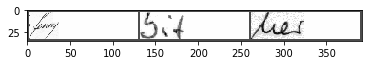

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 102, Loss: 11.325975666046142 

Targets:  ('but', 'R.', 'wife')
Predicted:  ['but', 'R.', 'wiff']


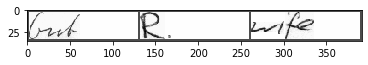

Epoch: 103, Loss: 1.2995, AvgLoss: 4.7847:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('a', 'galloped', 'said')
Predicted:  ['a', 'aalloped', 'saidd']


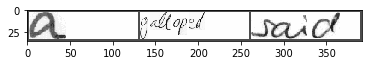

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 103, Loss: 11.008986530303956 

Targets:  ('the', 'of', 'he')
Predicted:  ['thee', 'oof', 'he']


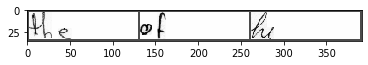

Epoch: 104, Loss: 0.8152, AvgLoss: 4.7490:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('that', 'Shem', 'action')
Predicted:  ['that', 'Shem', 'aaction']


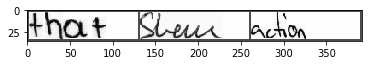

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 104, Loss: 11.103859825134277 

Targets:  ('fifteen', 'a', 'way')
Predicted:  ['fiftere', 'a', 'way']


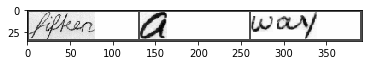

Epoch: 105, Loss: 0.6648, AvgLoss: 4.7118:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('his', 'teaching', 'world')
Predicted:  ['his', 'teeachingg', 'world']


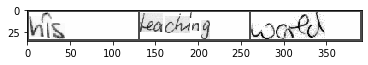

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 105, Loss: 10.927193145751954 

Targets:  ('studied', 'in', 'produced')
Predicted:  ['sttudiedd', 'in', 'prroduced']


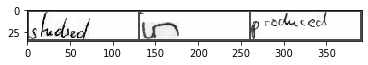

Epoch: 106, Loss: 0.4499, AvgLoss: 4.6729:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('conductor', 'arranging', 'tests')
Predicted:  ['conductlr', 'aarramgiing', 'tests']


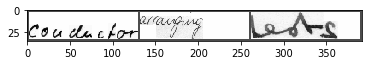

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 106, Loss: 11.075163688659668 

Targets:  ('a', 'fighting', 'and')
Predicted:  ['a', 'fashtingg', 'and']


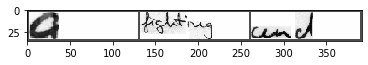

Epoch: 107, Loss: 0.4188, AvgLoss: 4.6337:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('the', 'a', 'going')
Predicted:  ['the', 'a', 'goiiing']


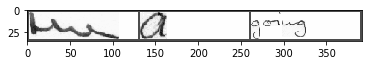

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 107, Loss: 11.341283531188965 

Targets:  ('of', 'in', 'an')
Predicted:  ['of', 'iin', 'an']


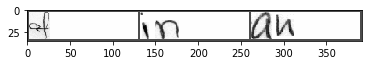

Epoch: 108, Loss: 0.5264, AvgLoss: 4.5952:  51%|█████     | 100/197 [01:06<01:02,  1.56it/s]


Targets:  ('his', 'this', 'losing')
Predicted:  ['his', 'this', 'losiingg']


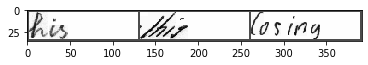

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 108, Loss: 11.255942134857177 

Targets:  ('the', 'the', 'accord')
Predicted:  ['thee', 'the', 'accord']


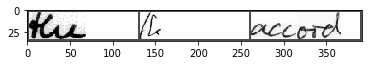

Epoch: 109, Loss: 0.5015, AvgLoss: 4.5589:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('than', 'betaken', 'me')
Predicted:  ['than', 'betaken', 'me']


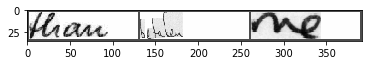

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 109, Loss: 11.286766567230224 

Targets:  ('as', 'like', 'arrangements')
Predicted:  ['as', 'like', 'arrrangemmentts']


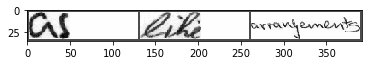

Epoch: 110, Loss: 0.6883, AvgLoss: 4.5234:  51%|█████     | 100/197 [01:06<01:02,  1.55it/s]


Targets:  ('Thackeray', '1ye', 'which')
Predicted:  ['TThackeraay', '1ye', 'which']


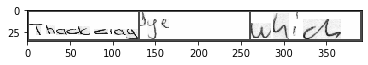

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 110, Loss: 11.393402156829834 

Targets:  ('quarters', 'The', 'forged')
Predicted:  ['quarturs', 'TThe', 'forgeed']


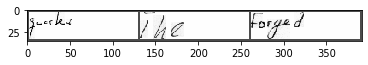

Epoch: 111, Loss: 0.5801, AvgLoss: 4.4889:  51%|█████     | 100/197 [01:06<01:02,  1.54it/s]


Targets:  ('on', 'The', 'simple')
Predicted:  ['on', 'TThe', 'simpee']


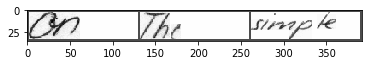

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch: 111, Loss: 11.291455898284912 

Targets:  ('truth', 'be', 'available')
Predicted:  ['trutf', 'be', 'aavaiiilable']


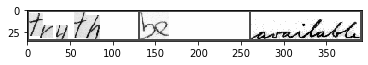

Epoch: 112, Loss: 0.9053, AvgLoss: 4.4592:  51%|█████     | 100/197 [01:06<01:02,  1.54it/s]


Targets:  ('intellectual', 'an', 'film')
Predicted:  ['inneccecual', 'an', 'film']


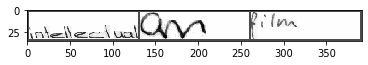

Epoch: 112, Loss: 0.9385, AvgLoss: 4.4590:  51%|█████▏    | 101/197 [01:08<01:38,  1.03s/it]

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py in __call__(self=CTCLoss(), *input=(tensor([[[ 0.0000e+00, -3.5065e+01, -3.7976e+01,...evice='cuda:0',
       grad_fn=<PermuteBackward>), tensor([[ 98, 101,   0,  ...,   0,   0,   0],
  ...111, 116,  ...,   0,   0,   0]], device='cuda:0'), tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, ... 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16]), tensor([ 2,  3,  4,  3,  3,  3,  8, 10,  7,  5, ...  4,  5,
         2,  3,  2, 11,  6,  1,  8,  6])), **kwargs={})
    530             result = self._slow_forward(*input, **kwargs)
    531         else:
--> 532             result = self.forward(*input, **kwargs)
        result = undefined
        self.forward = <bound method CTCLoss.forward of CTCLoss()>
        input = (tensor([[[ 0.0000e+00, -3.5065e+01, -3.7976e+01,  ..., -3.9199e+0

In [65]:
recognizer, train_losses, val_losses = train()

In [0]:
torch.save(recognizer.state_dict(), 'recognizer.model')

### Results

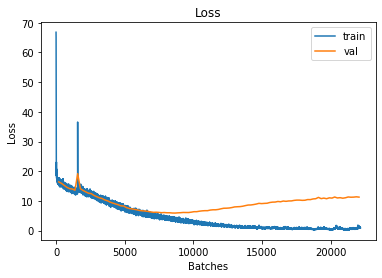

In [69]:
# Plot the Loss
tl_len = len(train_losses)
vl_len = len(val_losses)
y, x = val_losses, range(tl_len // vl_len, tl_len + 1, tl_len // vl_len)
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
plt.plot(x, y, label='val')
plt.legend()
plt.show()